# Machine Learning in Python - Group Project 1

**Due Friday, March 10th by 16.00 pm.**

Elliot Leishman etc.

## General Setup

In [1]:
# Add any additional libraries or submodules below

# Data libraries
import numpy as np
import pandas as pd

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats


# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules that are necessary
import sklearn

In [2]:
# Load data
data = pd.read_csv("the_office.csv")

After making sure that all the necessary libraries or submodules are uploaded here, please follow the given skeleton to create your project report. 
- Your completed assignment must follow this structure 
- You should not add or remove any of these sections, if you feel it is necessary you may add extra subsections within each (such as *2.1. Encoding*). 

**Do not forget to remove the instructions for each section in the final document.**

## 1. Introduction

*This section should include a brief introduction to the task and the data (assume this is a report you are delivering to a client).* 

- If you use any additional data sources, you should introduce them here and discuss why they were included.

- Briefly outline the approaches being used and the conclusions that you are able to draw.

## 2. Exploratory Data Analysis and Feature Engineering

*Include a detailed discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling.* 

- Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up. 
- Think carefully about whether each plot needs to be included in your final draft - your report should include figures but they should be as focused and impactful as possible.

*Additionally, this section should also implement and describe any preprocessing / feature engineering of the data.*

- Specifically, this should be any code that you use to generate new columns in the data frame `d`. All of this processing is explicitly meant to occur before we split the data in to training and testing subsets. 
- Processing that will be performed as part of an sklearn pipeline can be mentioned here but should be implemented in the following section.*

**All code and figures should be accompanied by text that provides an overview / context to what is being done or presented.**

In [3]:
# Brief Overview of the data
print(data.columns)
data.info()
data.describe().round(2)
data

Index(['season', 'episode', 'episode_name', 'director', 'writer',
       'imdb_rating', 'total_votes', 'air_date', 'n_lines', 'n_directions',
       'n_words', 'n_speak_char', 'main_chars'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   season        186 non-null    int64  
 1   episode       186 non-null    int64  
 2   episode_name  186 non-null    object 
 3   director      186 non-null    object 
 4   writer        186 non-null    object 
 5   imdb_rating   186 non-null    float64
 6   total_votes   186 non-null    int64  
 7   air_date      186 non-null    object 
 8   n_lines       186 non-null    int64  
 9   n_directions  186 non-null    int64  
 10  n_words       186 non-null    int64  
 11  n_speak_char  186 non-null    int64  
 12  main_chars    186 non-null    object 
dtypes: float64(1), int64(7), object(

,season,episode,episode_name,director,writer,imdb_rating,total_votes,air_date,n_lines,n_directions,n_words,n_speak_char,main_chars
0,1,1,Pilot,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels,7.6,3706,2005-03-24,229,27,2757,15,Angela;Dwight;Jim;Kevin;Michael;Oscar;Pam;Phyl...
1,1,2,Diversity Day,Ken Kwapis,B.J. Novak,8.3,3566,2005-03-29,203,20,2808,12,Angela;Dwight;Jim;Kelly;Kevin;Michael;Oscar;Pa...
2,1,3,Health Care,Ken Whittingham,Paul Lieberstein,7.9,2983,2005-04-05,244,21,2769,13,Angela;Dwight;Jim;Kevin;Meredith;Michael;Oscar...
3,1,4,The Alliance,Bryan Gordon,Michael Schur,8.1,2886,2005-04-12,243,24,2939,14,Angela;Dwight;Jim;Kevin;Meredith;Michael;Oscar...
4,1,5,Basketball,Greg Daniels,Greg Daniels,8.4,3179,2005-04-19,230,49,2437,18,Angela;Darryl;Dwight;Jim;Kevin;Michael;Oscar;P...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,9,19,Stairmageddon,Matt Sohn,Dan Sterling,8.0,1484,2013-04-11,273,59,2965,24,Andy;Angela;Creed;Dwight;Erin;Jim;Kevin;Meredi...
182,9,20,Paper Airplane,Jesse Peretz,Halsted Sullivan;Warren Lieberstein,8.0,1482,2013-04-25,234,48,2564,27,Andy;Angela;Creed;Darryl;Dwight;Erin;Jim;Kevin...
183,9,21,Livin' the Dream,Jeffrey Blitz,Nicki Schwartz-Wright,8.9,2041,2013-05-02,382,33,4333,20,Andy;Angela;Creed;Darryl;Dwight;Erin;Jim;Kevin...
184,9,22,A.A.R.M,David Rogers,Brent Forrester,9.3,2860,2013-05-09,501,54,4965,30,Andy;Angela;Creed;Darryl;Dwight;Erin;Jim;Kevin...


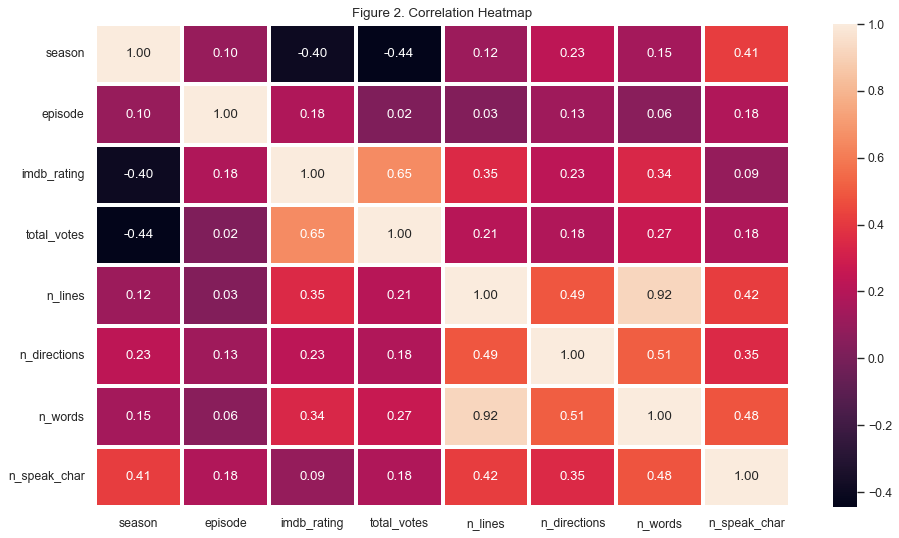

In [4]:
# Correlation
sns.set(rc={'figure.figsize': (14, 8)})
sns.heatmap(data.corr(), annot = True, fmt = '.2f', linewidths = 2)
plt.title("Figure 2. Correlation Heatmap")
plt.show()

Can very clearly see that n_words and n_lines are very highly positively correlated as we might expect, therefore we might not want to use both in our model? 
Note that the next highest postive correlation is between total_votes and imbd_rating.
Since imdb rating is what we want to maximise we would expect for our model to suggest...

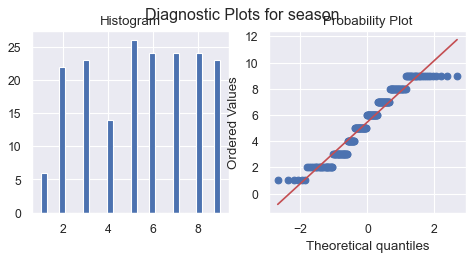

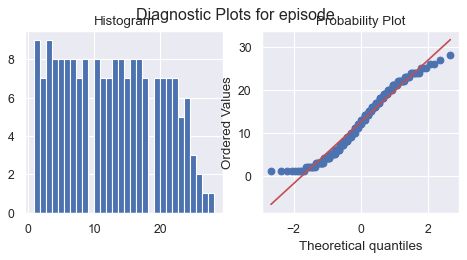

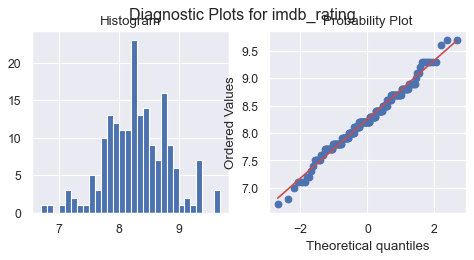

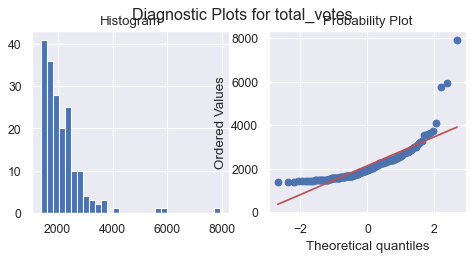

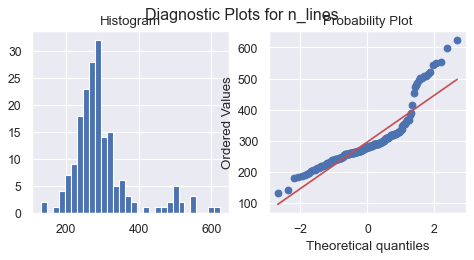

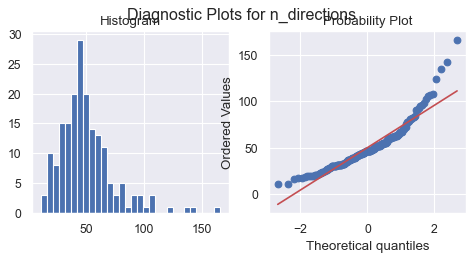

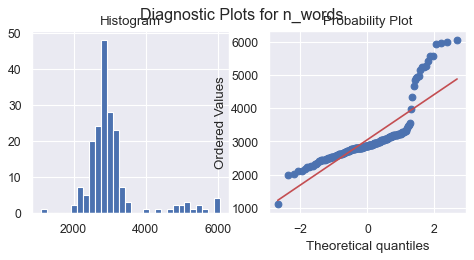

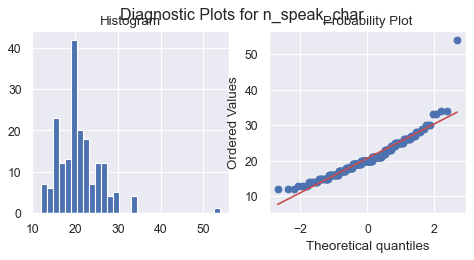

In [5]:
# Distributions - from Python Feature Engineering Cookbook
def diagnostic_plots(df, variable): 
    plt.figure(figsize=(7,3)) 
    plt.subplot(1, 2, 1) 
    df[variable].hist(bins=30)
    plt.title("Histogram")
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt) 
    plt.suptitle("Diagnostic Plots for {}".format(variable))
    plt.show()

for variable_name in data.select_dtypes(exclude = 'object'): # excludes columns with data type object
    diagnostic_plots(data, variable_name)

Note that imbd rating and n_speak_char are 'close' to being normally distributed

In [6]:
# Investigating effect of characters on imdb rating
chars = data['main_chars']
chars = chars.str.split(';', expand = False)
chars = pd.get_dummies(chars.apply(pd.Series).stack()).sum(level=0)

chars2 = pd.merge(data['imdb_rating'], chars, left_index=True, right_index=True)
chars2
# Dont know what to do with this now.

/var/folders/pg/_8g2r3zj2sz4xg237h264xjw0000gn/T/ipykernel_4867/1051159281.py:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  chars = pd.get_dummies(chars.apply(pd.Series).stack()).sum(level=0)


,imdb_rating,Andy,Angela,Creed,Darryl,Dwight,Erin,Jim,Kelly,Kevin,Meredith,Michael,Oscar,Pam,Phyllis,Ryan,Stanley,Toby
0,7.6,0,1,0,0,1,0,1,0,1,0,1,1,1,1,1,1,0
1,8.3,0,1,0,0,1,0,1,1,1,0,1,1,1,0,1,1,1
2,7.9,0,1,0,0,1,0,1,0,1,1,1,1,1,0,1,1,0
3,8.1,0,1,0,0,1,0,1,0,1,1,1,1,1,1,1,1,1
4,8.4,0,1,0,1,1,0,1,0,1,0,1,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,8.0,1,1,1,0,1,1,1,0,1,1,0,1,1,1,0,1,1
182,8.0,1,1,1,1,1,1,1,0,1,0,0,1,1,0,0,1,1
183,8.9,1,1,1,1,1,1,1,0,1,1,0,1,1,1,0,1,1
184,9.3,1,1,1,1,1,1,1,0,1,1,0,1,1,1,0,1,0


## 3. Model Fitting and Tuning

*In this section you should detail your choice of model and describe the process used to refine and fit that model.*

- You are strongly encouraged to explore many different modeling methods (e.g. linear regression, regression trees, lasso, etc.) but you should not include a detailed narrative of all of these attempts. 
- At most this section should mention the methods explored and why they were rejected - most of your effort should go into describing the model you are using and your process for tuning and validatin it.

*For example if you considered a linear regression model, a classification tree, and a lasso model and ultimately settled on the linear regression approach then you should mention that other two approaches were tried but do not include any of the code or any in depth discussion of these models beyond why they were rejected. This section should then detail is the development of the linear regression model in terms of features used, interactions considered, and any additional tuning and validation which ultimately led to your final model.* 

**This section should also include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.**

In [11]:
# Splitting into test and train data
from sklearn.model_selection import train_test_split

X = data.drop('imdb_rating', axis = 1) # Set of features
y = data['imdb_rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
X_test.head()

,season,episode,episode_name,director,writer,total_votes,air_date,n_lines,n_directions,n_words,n_speak_char,main_chars
41,3,15,Ben Franklin,Randall Einhorn,Mindy Kaling,2254,2007-02-01,257,23,2330,17,Angela;Dwight;Jim;Kelly;Kevin;Meredith;Michael...
19,2,14,The Carpet,Victor Nelli Jr.,Paul Lieberstein,2342,2006-01-26,261,67,2758,21,Angela;Creed;Darryl;Dwight;Jim;Kelly;Kevin;Mic...
160,8,22,Fundraiser,David Rogers,Owen Ellickson,1453,2012-04-26,239,31,2859,21,Andy;Angela;Creed;Darryl;Dwight;Erin;Jim;Kevin...
52,4,3,Dunder Mifflin Infinity (Parts 1&2),Craig Zisk,Michael Schur,2248,2007-10-04,551,108,5567,20,Andy;Angela;Creed;Dwight;Jim;Kelly;Kevin;Micha...
112,6,24,The Cover,Rainn Wilson,Gene Stupnitsky;Lee Eisenberg,1627,2010-05-06,308,62,3111,19,Andy;Creed;Darryl;Dwight;Erin;Jim;Kelly;Meredi...


## 4. Discussion and Conclusions


*In this section you should provide a general overview of **your final model**, its **performance**, and **reliability**.* 

- You should discuss what the implications of your model are in terms of the included features, predictive performance, and anything else you think is relevant.

- This should be written with a target audience of a NBC Universal executive who is with the show and university level mathematics but not necessarily someone who has taken a postgraduate statistical modeling course. 

- Your goal should be to convince this audience that your model is both accurate and useful.

- Finally, you should include concrete recommendations on what NBC Universal should do to make their reunion episode a popular as possible.

**Keep in mind that a negative result, i.e. a model that does not work well predictively, but that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explanations / justifications.**

## 5. References

*In this section, you should present a list of external sources (except the course materials) that you used during the project, if any*

- Additional data sources can be cited here, in addition to related python documentations, any other webpage sources that you benefited from